In [1]:
import glob
import os
import sys
from pathlib import Path

import numpy as np
import torch

# 当前目录
current_dir = os.path.dirname(os.path.abspath("__file__"))
# 上一级目录
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)
# 上两级目录
grandparent_dir = os.path.abspath(os.path.join(parent_dir, ".."))
sys.path.append(grandparent_dir)

from config_plot import *
from data import get_data
from dynamic_single_pendulum_DAE import DynamicSinglePendulumDAE
from integrator import ODEIntegrate
from network import DAE_NN
from utils import (
    Logger,
    count_parameters,
    from_pickle,
    load_network,
    read_config_file,
    set_random_seed,
    tensors_to_numpy,
    to_pickle,
)

In [2]:
# 库
import cv2
from data import decoder_pixel2point, encoder_point2pixel
from dynamic_single_pendulum_DAE import DynamicSinglePendulumDAE

# config

In [3]:
######################################################################
#
# env config
#
######################################################################
# Env
set_random_seed(random_seed=0)
os.makedirs(output_dir, exist_ok=True)

# Logger
logger = Logger(output_dir)

# Config
config_file_path = "/home/lbu/project/pixels_hnn/ex_single_pendulum4/config.py"
config = read_config_file(config_file_path)

# function

In [4]:
######################################################################
#
# function
#
######################################################################
def truncated_lambdas(values, dof):
    """
    截断lambda值。

    Args:
        values: lambda值

    Returns:
        torch.Tensor: 截断后的lambda值
    """
    q, qt, lambdas = torch.tensor_split(values, (dof, dof * 2), dim=-1)
    return torch.cat([q, qt], dim=-1)


def handle_DAE_structure(y0, y, yt):
    y = y.squeeze()
    y0 = y[0].reshape(1, -1)
    yt = yt.squeeze()

    y = truncated_lambdas(y, config.dof)
    y0 = truncated_lambdas(y0, config.dof)
    yt = truncated_lambdas(yt, config.dof)

    return y0, y, yt


def calculate_evaluation_metrics(t, y, yt, calculator):
    """
    计算评估指标 -> 状态，能量，约束
    return: (dtype: numpy)
            t
            q, qt, qtt,
            energy, kinetic, potential, energy_error
            phi, phi_t, phi_tt
    """
    # 数据预处理
    t, y, yt = tensors_to_numpy(t, y, yt)
    q, qt = np.split(y, 2, axis=-1)
    qt, qtt = np.split(yt, 2, axis=-1)
    all_states = np.concatenate([q, qt, qtt], axis=-1)

    # 计算能量
    energy = calculator.energy(q, qt)
    energy_error = calculator.energy(q, qt) - calculator.energy(q, qt)[0]
    kinetic = calculator.kinetic(q, qt)
    potential = calculator.potential(q, qt)

    # 计算约束
    phi = calculator.phi(q, qt, qtt)
    phi_t = calculator.phi_t(q, qt, qtt)
    phi_tt = calculator.phi_tt(q, qt, qtt)

    return t, q, qt, qtt, energy, kinetic, potential, energy_error, phi, phi_t, phi_tt


def create_single_pendulum_grayscale_image(y, time, multiple=int(1e3)):
    """
    参数：
        y: 全部轨迹
        time: 选取画出的单摆时刻
        multiple: 图像横向尺寸

    返回值：
        单摆灰度图
    """

    # 创建一个空白灰度图像数组
    image_width = multiple + 1  # 尺寸，保证取到中点
    image_line = image_width * 2  # 尺寸，根据单摆图像特征设置
    result_image = np.zeros((image_width, image_line), dtype=np.uint8)

    # 天花板
    color = 255
    line_thickness = 50
    start_point = (0, 0)
    end_point = (image_line, 0)
    cv2.line(result_image, start_point, end_point, color, line_thickness)

    # 顶端中点
    color = 255
    radius = 50
    point_coordinates = (int(image_line / 2), 0)
    cv2.circle(result_image, point_coordinates, radius, color, -1)

    # 小球
    color = 255
    radius = 50
    encoder_point = encoder_point2pixel(y, multiple)
    point_coordinates_x = int(tensors_to_numpy(encoder_point[time, 0]))
    point_coordinates_y = int(tensors_to_numpy(encoder_point[time, 1]))
    point_coordinates = (point_coordinates_x, point_coordinates_y)
    cv2.circle(result_image, point_coordinates, radius, color, -1)

    # 绳子
    color = 100
    line_thickness = 25
    start_point = (int(image_line / 2), 0)
    end_point = point_coordinates
    cv2.line(result_image, start_point, end_point, color, line_thickness)

    # 设置特殊点
    color = 111
    result_image[point_coordinates_y, point_coordinates_x] = color

    return result_image

# infer

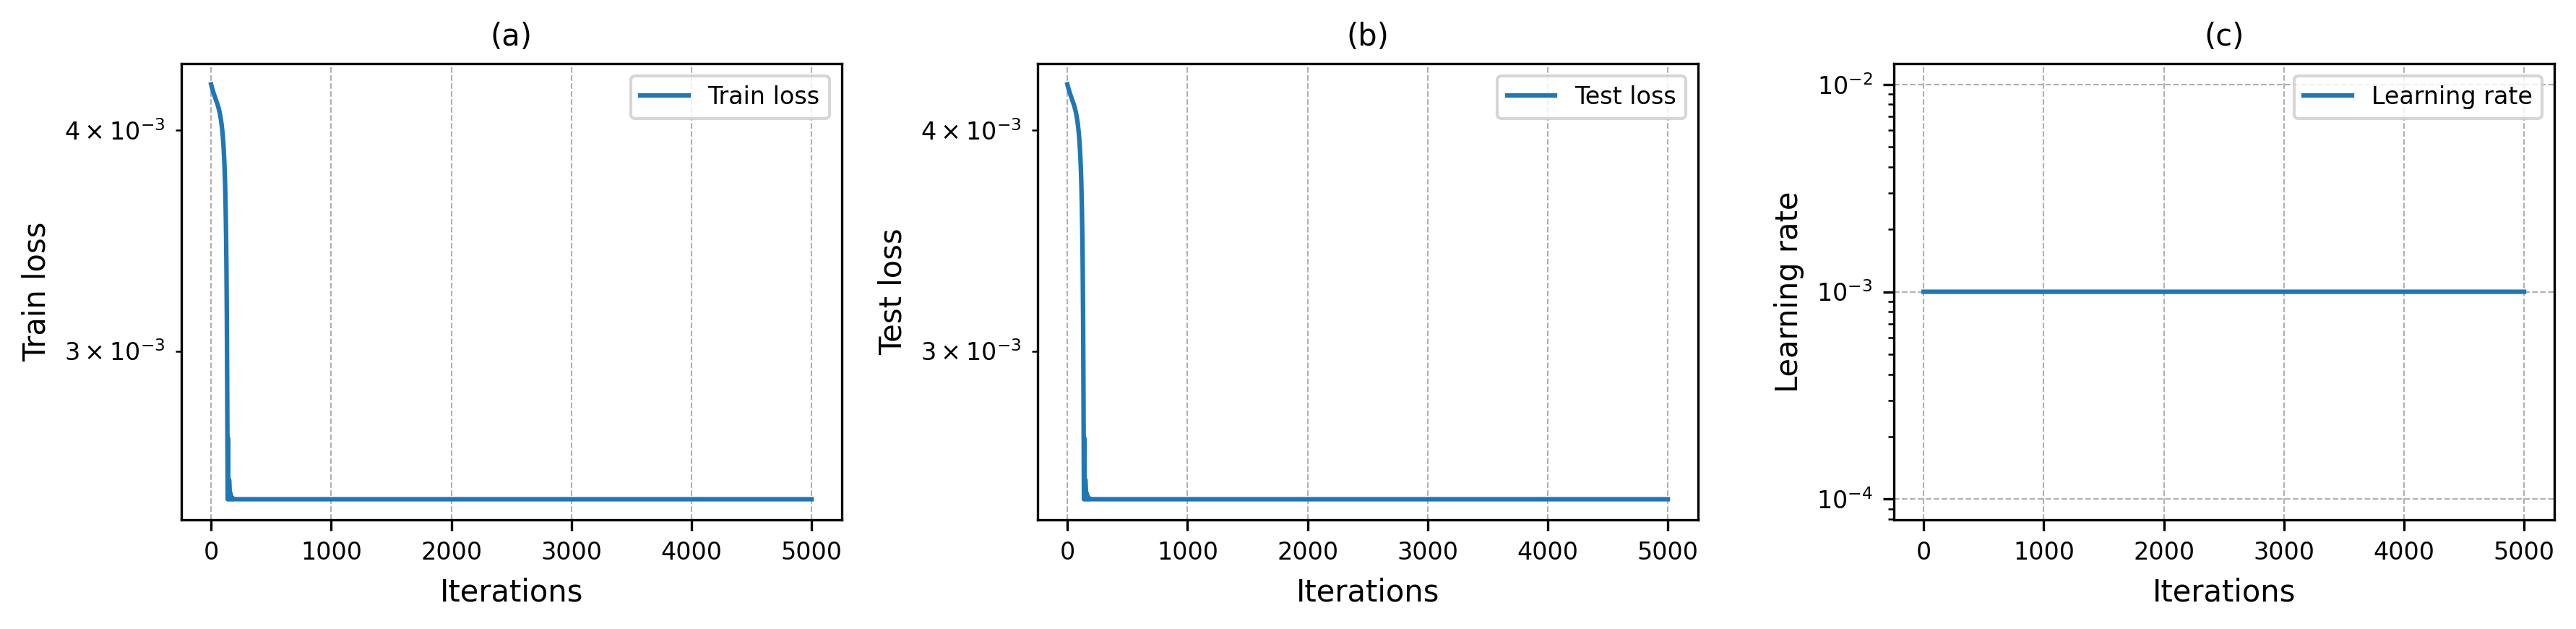

In [5]:
######################################################################
#
# plot loss
#
######################################################################
path = "/home/lbu/project/pixels_hnn/ex_single_pendulum4/outputs/loss.pkl"
loss_info = from_pickle(path)
iterations = loss_info["iter"]
train_loss = loss_info["train_loss"]
test_loss = loss_info["test_loss"]

fig, axs = plt.subplots(1, 3, figsize=(4 * 3, 3 * 1), dpi=Latex_DPI)

subfig = axs[0]
subfig.set_title("(a)")
subfig.set_xlabel("Iterations")
subfig.set_ylabel("Train loss")
subfig.plot(iterations, train_loss, label="Train loss")
subfig.set_yscale("log")
subfig.legend()

subfig = axs[1]
subfig.set_title("(b)")
subfig.set_xlabel("Iterations")
subfig.set_ylabel("Test loss")
subfig.plot(iterations, train_loss, label="Test loss")
subfig.set_yscale("log")
subfig.legend()

subfig = axs[2]
subfig.set_title("(c)")
subfig.set_xlabel("Iterations")
subfig.set_ylabel("Learning rate")
subfig.set_yscale("log")
subfig.plot(iterations, len(iterations) * [config.learning_rate], label="Learning rate")
subfig.legend()

plt.tight_layout()

solving ODE...: 100%|████████████████████████| 500/500 [00:00<00:00, 666.13it/s]


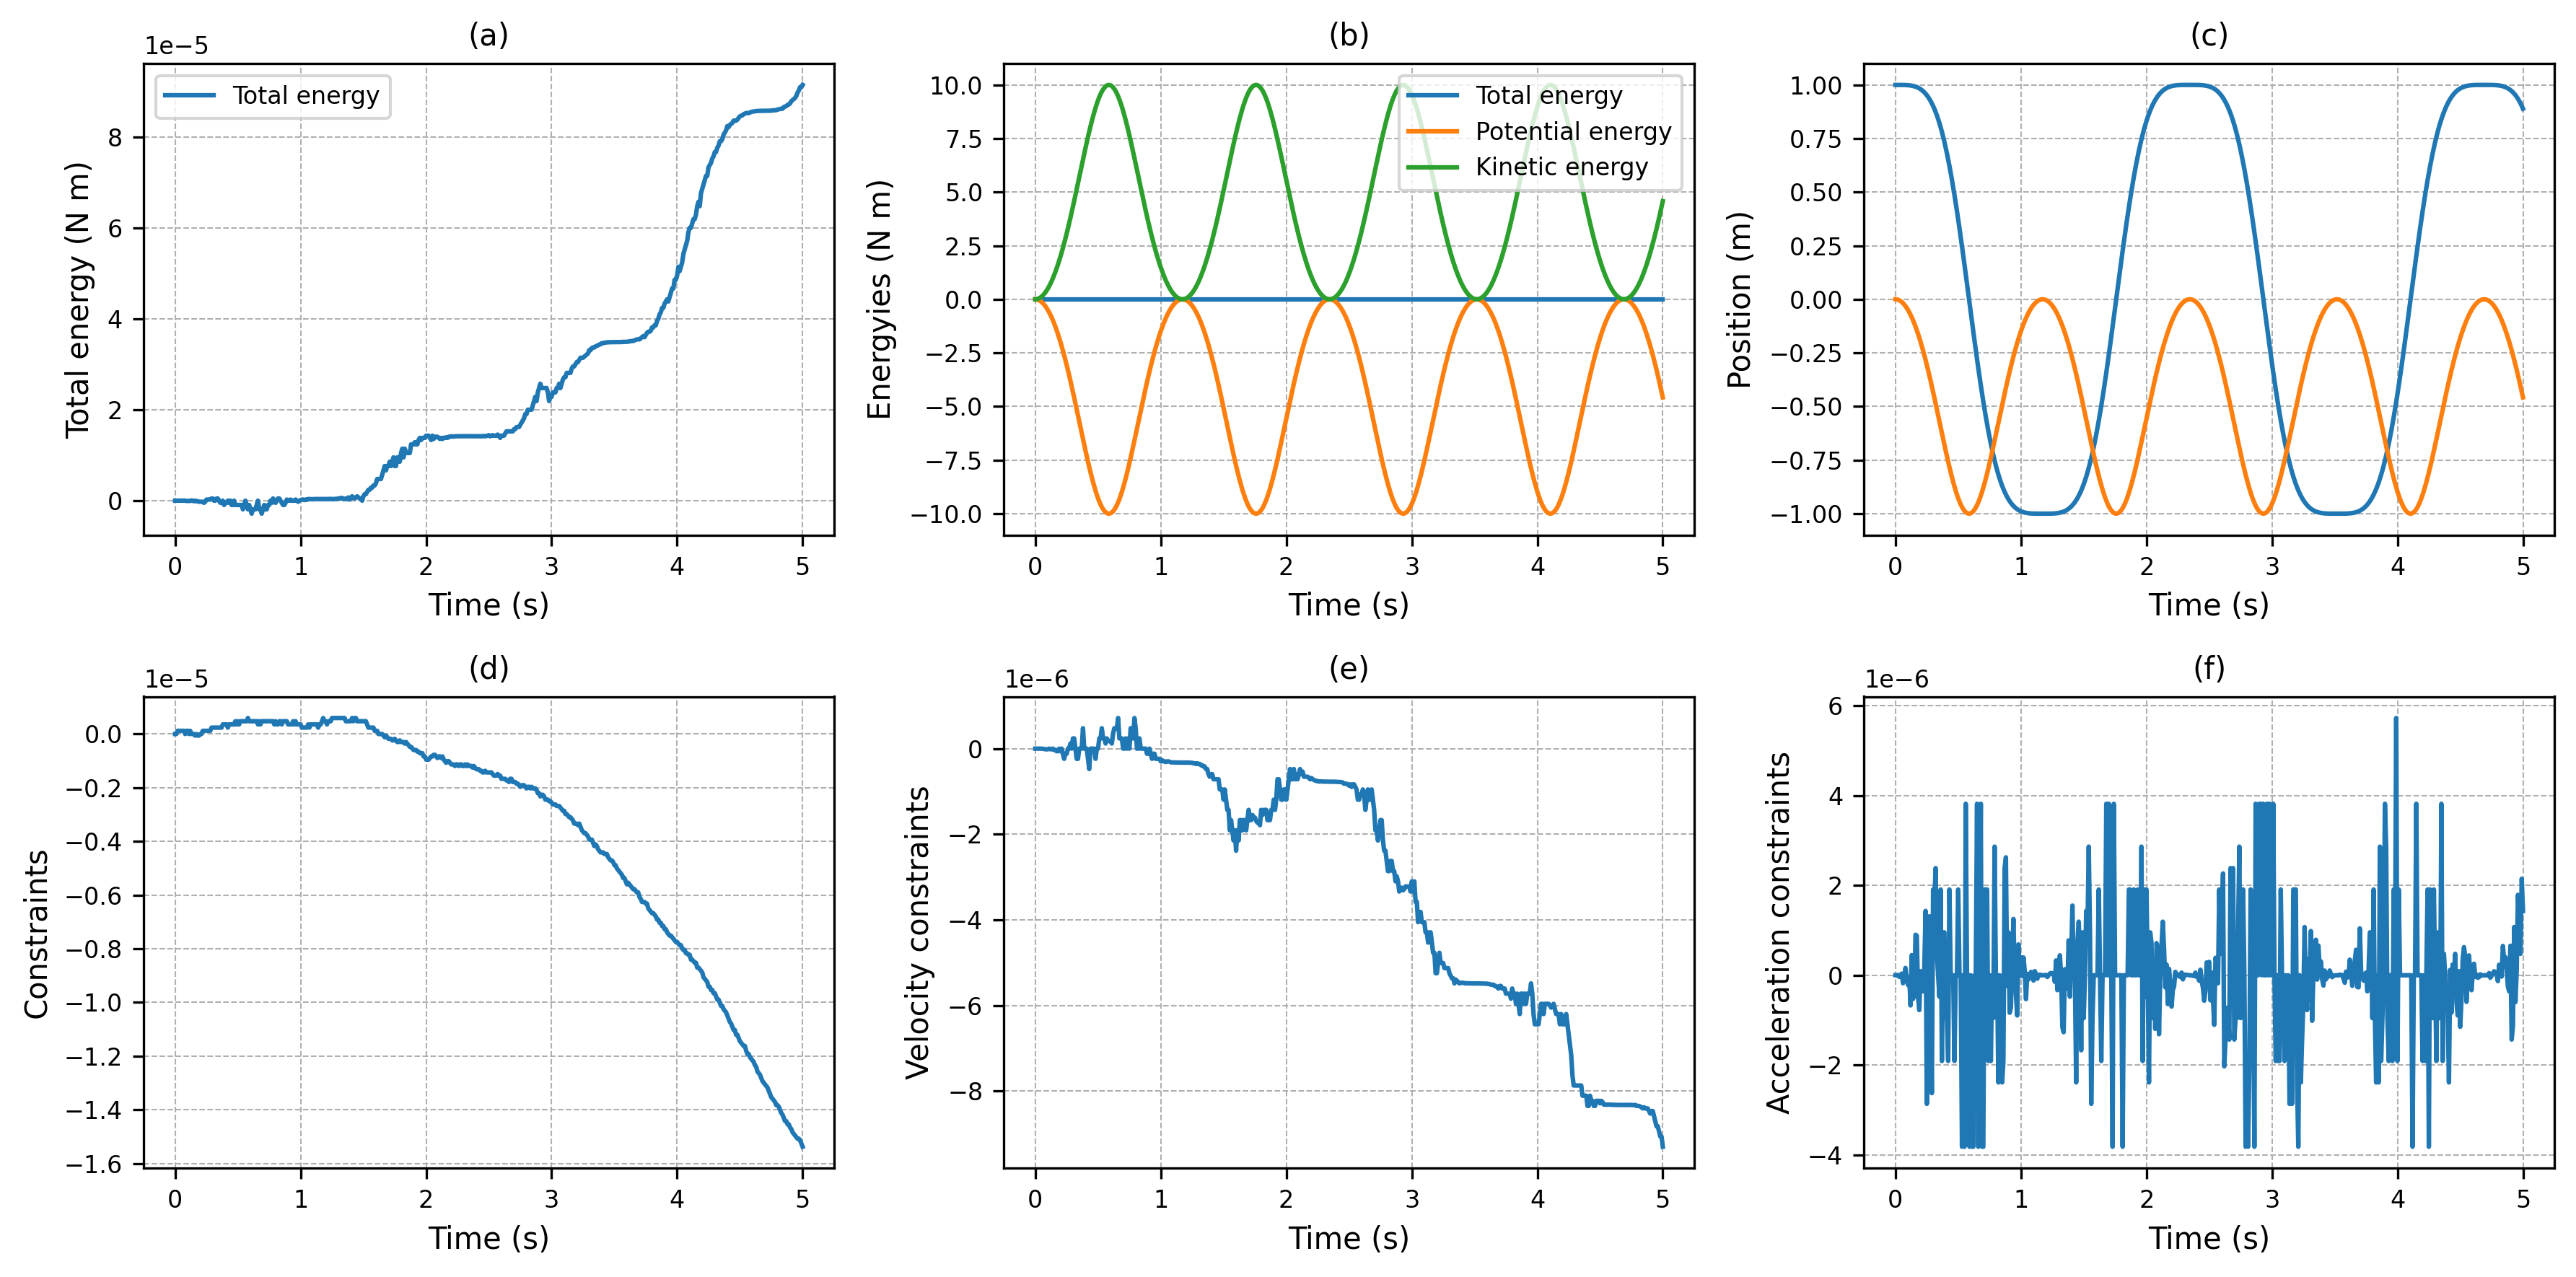

In [6]:
######################################################################
#
# rk4 model
#
######################################################################
# 初始条件
y0 = torch.tensor(config.y0, device=config.device, dtype=config.dtype)
y0 = y0.repeat(config.data_num, 1)

# 求解动力学方程
dynamics = DynamicSinglePendulumDAE(config, logger)
data_t, y = ODEIntegrate(
    func=dynamics,
    t0=config.t0,
    t1=config.t1,
    dt=config.dt,
    y0=y0,
    method=config.ode_solver,
    device=config.device,
    dtype=config.dtype,
    dof=config.dof,
)
yt = torch.stack([dynamics(data_t, yi).clone().detach().cpu() for yi in y])
y0, y, yt = handle_DAE_structure(y0, y, yt)

# 计算评价指标
calculator = DynamicSinglePendulumDAE(config, logger).calculator

(
    data_t,
    q,
    qt,
    qtt,
    energy,
    kinetic,
    potential,
    energy_error,
    phi,
    phi_t,
    phi_tt,
) = calculate_evaluation_metrics(data_t, y, yt, calculator)

# plot results
fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 3 * 2), dpi=Latex_DPI)

subfig = axs[0, 0]
subfig.set_title("(a)")
subfig.set_xlabel("Time (s)")
subfig.set_ylabel("Total energy (N m)")
subfig.plot(data_t, energy, label="Total energy")
subfig.legend()

subfig = axs[0, 1]
subfig.set_title("(b)")
subfig.set_xlabel("Time (s)")
subfig.set_ylabel("Energyies (N m)")
subfig.plot(data_t, energy, label="Total energy")
subfig.plot(data_t, potential, label="Potential energy")
subfig.plot(data_t, kinetic, label="Kinetic energy")
subfig.legend()

subfig = axs[0, 2]
subfig.set_title("(c)")
subfig.set_xlabel("Time (s)")
subfig.set_ylabel("Position (m)")
subfig.plot(data_t, q[:,])
# subfig.legend()

subfig = axs[1, 0]
subfig.set_title("(d)")
subfig.set_xlabel("Time (s)")
subfig.set_ylabel("Constraints")
subfig.plot(data_t, phi[:,], label="Constraint")
# subfig.legend()

subfig = axs[1, 1]
subfig.set_title("(e)")
subfig.set_xlabel("Time (s)")
subfig.set_ylabel("Velocity constraints")
subfig.plot(data_t, phi_t[:,], label="Velocity constraint")
# subfig.legend()

subfig = axs[1, 2]
subfig.set_title("(f)")
subfig.set_xlabel("Time (s)")
subfig.set_ylabel("Acceleration constraints")
subfig.plot(data_t, phi_tt[:,], label="Acceleration constraint")
# subfig.legend()

plt.tight_layout()

In [7]:
y.shape, yt.shape

(torch.Size([501, 4]), torch.Size([501, 4]))

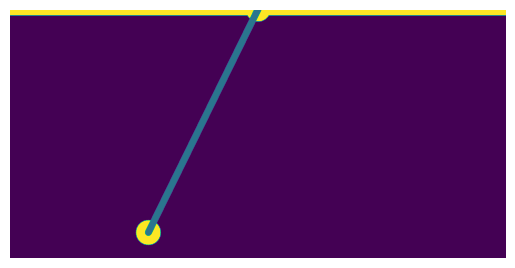

In [8]:
######################################################################
#
# 创建单摆图像
#
######################################################################
single_pendulum_image = create_single_pendulum_grayscale_image(y=y, time=400)
plt.axis("off")
plt.imshow(single_pendulum_image)

In [9]:
######################################################################
#
# 从图像中读取位置坐标和速度
#
######################################################################
# 创建两幅图像
time1_image = create_single_pendulum_grayscale_image(y=y, time=400)
time2_image = create_single_pendulum_grayscale_image(y=y, time=401)

# 寻找标记点(从图像中读取的位置坐标是y，x)
time1_pixel_point = np.where(time1_image == 111)
time1_pixel_point = (time1_pixel_point[1], time1_pixel_point[0])
time2_pixel_point = np.where(time2_image == 111)
time2_pixel_point = (time2_pixel_point[1], time2_pixel_point[0])

# 获得标记点坐标和速度
time1_pixel_point = np.concatenate([time1_pixel_point], axis=-1)
time1_pixel_point = torch.from_numpy(time1_pixel_point).reshape(1, -1)

time2_pixel_point = np.concatenate([time2_pixel_point], axis=-1)
time2_pixel_point = torch.from_numpy(time2_pixel_point).reshape(1, -1)

time1_point_states = decoder_pixel2point(
    time1_pixel_point, time2_pixel_point, multiple=int(1e3)
)
time1_point_states, y[400, :]

(tensor([[-0.4420, -0.8980,  3.8000, -1.8000]]),
 tensor([-0.4418, -0.8971,  3.8001, -1.8713], device='cuda:0'))

In [10]:
######################################################################
#
# 根据轨迹数据，encoder（转换为图像像素点），decoder（从图像像素点转换为坐标）
#
######################################################################
encoder_point = encoder_point2pixel(y, multiple=1e3)
y_hat = decoder_pixel2point(encoder_point[:-1], encoder_point[1:], multiple=1e3)
y_hat, y

(tensor([[ 1.0000e+00,  0.0000e+00, -1.0000e-01, -1.0000e-01],
         [ 9.9900e-01, -1.0000e-03,  0.0000e+00, -1.0000e-01],
         [ 9.9900e-01, -2.0000e-03,  0.0000e+00, -3.0000e-01],
         ...,
         [ 9.2500e-01, -3.7900e-01, -1.1000e+00, -2.6000e+00],
         [ 9.1400e-01, -4.0500e-01, -1.2000e+00, -2.6000e+00],
         [ 9.0200e-01, -4.3100e-01, -1.3000e+00, -2.7000e+00]], device='cuda:0'),
 tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0000e+00, -5.0000e-04, -5.0000e-05, -1.0000e-01],
         [ 1.0000e+00, -2.0000e-03, -4.0000e-04, -2.0000e-01],
         ...,
         [ 9.1443e-01, -4.0472e-01, -1.1515e+00, -2.6017e+00],
         [ 9.0235e-01, -4.3098e-01, -1.2653e+00, -2.6493e+00],
         [ 8.8911e-01, -4.5768e-01, -1.3847e+00, -2.6900e+00]], device='cuda:0'))